# Relatório do Projeto

##### 
Neste notebook, vamos analisar o desempenho dos diferentes algoritmos de IA implementados para o jogo Connect4. O objetivo é comparar:
- Taxas de vitória/derrota/empate
- Tempos de resposta
- Eficácia em diferentes fases do jogo
- Qualidade das decisões tomadas

## Análise Comparativa

#####
Vou analisar cada um dos três algoritmos de IA (A*, MCTS e Árvore de Decisão) comparando seu desempenho entre si, IA vs IA, para obter um enquadramento sobre como elas se comportam entre si.




### Configuração Inicial

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from game import constants as c
from game import rules as game
from ai import a_star, mcts, decision_tree, heuristic
from game.board import Board

# Inicialização dos algoritmos
ai_algorithms = {
    "A*": a_star.a_star,
    "MCTS": mcts.mcts,
    "Decision Tree": decision_tree.DecisionTree(mode='connect4').play
}

### 1.Análise de Desempenho (Vitórias/Derrotas/Empates)

In [ ]:
# Simulação de jogos entre dois algoritmos
def simulate_games(ai1, ai2, num_games=100):
    results = {'AI1 Wins': 0, 'AI2 Wins': 0, 'Draws': 0}
    times_ai1 = []
    times_ai2 = []
    
    for _ in range(num_games):
        board = np.zeros((c.ROWS, c.COLUMNS), dtype=int)
        current_player = c.PLAYER1_PIECE
        
        while True:
            start_time = time.time()
            if current_player == c.PLAYER1_PIECE:
                move = ai1(board)
                times_ai1.append(time.time() - start_time)
            else:
                move = ai2(board)
                times_ai2.append(time.time() - start_time)
            
            board = game.simulate_move(board, current_player, move)
            
            if game.winning_move(board, current_player):
                if current_player == c.PLAYER1_PIECE:
                    results['AI1 Wins'] += 1
                else:
                    results['AI2 Wins'] += 1
                break
                
            if game.is_game_tied(board):
                results['Draws'] += 1
                break
                
            current_player = c.PLAYER2_PIECE if current_player == c.PLAYER1_PIECE else c.PLAYER1_PIECE
    
    return results, np.mean(times_ai1), np.mean(times_ai2)

# Simular partidas entre pares de algoritmos
matchups = [
    ("A*", "MCTS"),
    ("A*", "Decision Tree"),
    ("MCTS", "Decision Tree")
]

results_data = []

for ai1_name, ai2_name in matchups:
    ai1 = ai_algorithms[ai1_name]
    ai2 = ai_algorithms[ai2_name]
    
    results, time_ai1, time_ai2 = simulate_games(ai1, ai2, num_games=50)
    
    results_data.append({
        'Matchup': f"{ai1_name} vs {ai2_name}",
        f'{ai1_name} Wins': results['AI1 Wins'],
        f'{ai2_name} Wins': results['AI2 Wins'],
        'Draws': results['Draws'],
        f'{ai1_name} Avg Time': time_ai1,
        f'{ai2_name} Avg Time': time_ai2
    })

# Criar DataFrame com os resultados
results_df = pd.DataFrame(results_data)
print(results_df)

# Gráficos de vitórias e empates por confronto
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, matchup in enumerate(matchups):
    ax = axes[i]
    matchup_df = results_df[results_df['Matchup'] == f"{matchup[0]} vs {matchup[1]}"]
    
    wins_data = {
        matchup[0]: matchup_df[f'{matchup[0]} Wins'].values[0],
        matchup[1]: matchup_df[f'{matchup[1]} Wins'].values[0],
        'Draws': matchup_df['Draws'].values[0]
    }
    
    pd.Series(wins_data).plot(kind='bar', ax=ax, title=f"{matchup[0]} vs {matchup[1]}")
    ax.set_ylabel('Number of Games')
    ax.set_xlabel('Result')

plt.tight_layout()
plt.show()

# Preparar dados de tempo médio para gráfico
time_data = []
for _, row in results_df.iterrows():
    for algo in ai_algorithms.keys():
        if f'{algo} Avg Time' in row:
            time_data.append({
                'Algorithm': algo,
                'Average Time (s)': row[f'{algo} Avg Time'],
                'Matchup': row['Matchup']
            })

time_df = pd.DataFrame(time_data)

# Gráfico de tempo médio de resposta por algoritmo (matplotlib puro)
plt.figure(figsize=(10, 6))

algorithms = sorted(time_df['Algorithm'].unique())
matchups = sorted(time_df['Matchup'].unique())

bar_width = 0.2
x = np.arange(len(algorithms))

for i, matchup in enumerate(matchups):
    subset = time_df[time_df['Matchup'] == matchup]
    positions = x + i * bar_width
    means = [subset[subset['Algorithm'] == algo]['Average Time (s)'].values[0] if algo in subset['Algorithm'].values else 0 for algo in algorithms]
    
    plt.bar(positions, means, width=bar_width, label=matchup)

plt.xticks(x + bar_width, algorithms)
plt.ylabel('Average Time (s)')
plt.title('Tempo Médio de Resposta por Algoritmo')
plt.legend(title='Matchup')
plt.tight_layout()
plt.show()


#####    
A função `simulate_games` executa partidas entre dois algoritmos:
- Mantém contagem de vitórias e empates
- Mede o tempo de resposta de cada algoritmo
- Simula jogadas alternadas até término do jogo

São definidos três confrontos:
- A* vs MCTS
- A* vs Árvore de Decisão
- MCTS vs Árvore de Decisão

Para cada confronto, são simuladas 50 partidas e coletados:
- Número de vitórias de cada algoritmo
- Número de empates
- Tempo médio de resposta

Resultados:
- MCTS foi o algoritmo mais forte, vencendo a maioria dos confrontos, possível de ser notar nos gráficos
- A* teve desempenho intermediário
- Árvore de Decisão teve o pior desempenho, apesar de ser a mais rápida
- MCTS teve os tempos de resposta mais longos, enquanto Árvore de Decisão foi o mais rápido
- Visualização evidente da diferença de tempo de processamento entre os algoritmos


### 2.Análise de Movimentos por Estágio do Jogo

In [ ]:
import random

def analyze_moves_by_stage(algorithm, num_games=20):
    stages = {
        'Early (Moves 1-10)': [],
        'Mid (Moves 11-20)': [],
        'Late (Moves 21+)': []
    }
    
    for _ in range(num_games):
        board = np.zeros((c.ROWS, c.COLUMNS), dtype=int)
        current_player = c.PLAYER1_PIECE
        move_count = 0
        
        while True:
            move_count += 1
            move = algorithm(board)
            board = game.simulate_move(board, current_player, move)
            
            # Avaliar qualidade do movimento
            if move_count <= 10:
                stage = 'Early (Moves 1-10)'
            elif move_count <= 20:
                stage = 'Mid (Moves 11-20)'
            else:
                stage = 'Late (Moves 21+)'
            
            # Simular resposta do oponente para avaliar a jogada
            opponent_move = random.choice(game.available_moves(board))
            opponent_board = game.simulate_move(board, 3 - current_player, opponent_move)
            
            score = heuristic.calculate_board_score(opponent_board, current_player, 3 - current_player)
            stages[stage].append(score)
            
            if game.winning_move(board, current_player) or game.is_game_tied(board):
                break
                
            current_player = c.PLAYER2_PIECE if current_player == c.PLAYER1_PIECE else c.PLAYER1_PIECE
    
    # Calcular estatísticas por estágio
    stats = {}
    for stage, scores in stages.items():
        if scores:
            stats[stage] = {
                'Avg Score': np.mean(scores),
                'Median Score': np.median(scores),
                'Std Dev': np.std(scores),
                'Count': len(scores)
            }
    
    return pd.DataFrame(stats).T

# Analisar cada algoritmo
stage_stats = {}
for algo_name, algo_func in ai_algorithms.items():
    stage_stats[algo_name] = analyze_moves_by_stage(algo_func)

# Visualizar resultados
for algo_name, stats in stage_stats.items():
    print(f"\n=== {algo_name} ===")
    display(stats)
    
    # Gráfico
    stats.reset_index().plot(x='index', y='Avg Score', kind='bar', 
                           title=f'{algo_name} - Average Move Quality by Game Stage',
                           ylabel='Average Heuristic Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#####
Divide o jogo em três estágios:
- Início (jogadas 1-10)
- Meio (jogadas 11-20)
- Fim (jogadas 21+)
Para cada movimento:
- Classifica em um estágio
- Avalia a qualidade usando a função heurística
- Simula uma resposta aleatória do oponente para avaliação
- Calcula estatísticas (média, mediana, desvio padrão) para cada estágio

Resultados:
- MCTS teve desempenho consistente em todos os estágios
- A* melhorou no final do jogo (onde a busca heurística é mais eficaz)
- Árvore de Decisão teve dificuldades no início do jogo
- Todos os algoritmos tiveram melhor desempenho no meio do jogo

### 3.Análise de Decisões Críticas

In [ ]:
def analyze_critical_situations(algorithm, num_games=30):
    situations = {
        'Win in 1': 0,
        'Block Opponent Win': 0,
        'Create Fork': 0,
        'Missed Win': 0,
        'Missed Block': 0
    }
    
    for _ in range(num_games):
        board = np.zeros((c.ROWS, c.COLUMNS), dtype=int)
        current_player = c.PLAYER1_PIECE
        
        while True:
            # Verificar situações antes da jogada da IA
            can_win = False
            can_block = False
            
            # Verificar se pode ganhar
            for col in game.available_moves(board):
                sim_board = game.simulate_move(board, current_player, col)
                if game.winning_move(sim_board, current_player):
                    can_win = True
                    break
            
            # Verificar se precisa bloquear
            for col in game.available_moves(board):
                sim_board = game.simulate_move(board, 3 - current_player, col)
                if game.winning_move(sim_board, 3 - current_player):
                    can_block = True
                    break
            
            # Fazer a jogada
            move = algorithm(board)
            board = game.simulate_move(board, current_player, move)
            
            # Avaliar a jogada
            if can_win:
                sim_board = game.simulate_move(board, current_player, move)
                if game.winning_move(sim_board, current_player):
                    situations['Win in 1'] += 1
                else:
                    situations['Missed Win'] += 1
            elif can_block:
                sim_board = game.simulate_move(board, 3 - current_player, move)
                if not game.winning_move(sim_board, 3 - current_player):
                    situations['Block Opponent Win'] += 1
                else:
                    situations['Missed Block'] += 1
            
            # Verificar se criou um fork (oportunidade de vitória em duas colunas)
            winning_options = 0
            for col in game.available_moves(board):
                sim_board = game.simulate_move(board, current_player, col)
                if game.winning_move(sim_board, current_player):
                    winning_options += 1
            if winning_options >= 2:
                situations['Create Fork'] += 1
            
            if game.winning_move(board, current_player) or game.is_game_tied(board):
                break
                
            current_player = c.PLAYER2_PIECE if current_player == c.PLAYER1_PIECE else c.PLAYER1_PIECE
    
    return pd.Series(situations)

# Analisar cada algoritmo
critical_stats = {}
for algo_name, algo_func in ai_algorithms.items():
    critical_stats[algo_name] = analyze_critical_situations(algo_func)

# Combinar resultados
critical_df = pd.DataFrame(critical_stats)

# Visualizar
display(critical_df)

# Gráfico
critical_df.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Desempenho em Situações Críticas')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#####
Analisa cinco situações críticas:
- Vitória em uma jogada
- Bloqueio de vitória do oponente
- Criação de fork (ameaça dupla)
- Vitórias perdidas
- Bloqueios não realizados

Para cada jogada:
- Verifica se há vitória imediata possível
- Verifica se precisa bloquear o oponente
- Avalia se a jogada escolhida aproveitou/evitou essas situações
- Verifica se criou ameaças múltiplas

Resultados:
- MCTS teve o melhor desempenho em situações críticas
- A* foi bom em vitórias imediatas, mas perdeu alguns bloqueios
- Árvore de Decisão cometeu mais erros em situações críticas
- Todos os algoritmos tiveram dificuldade em criar forks consistentemente

### 4.Análise de Tempo por Complexidade do Tabuleiro

In [ ]:
def analyze_time_by_complexity(algorithm, num_games=20):
    data = []
    
    for _ in range(num_games):
        board = np.zeros((c.ROWS, c.COLUMNS), dtype=int)
        current_player = c.PLAYER1_PIECE
        move_count = 0
        
        while True:
            move_count += 1
            pieces_on_board = np.count_nonzero(board)
            
            start_time = time.time()
            move = algorithm(board)
            elapsed = time.time() - start_time
            
            data.append({
                'Pieces on Board': pieces_on_board,
                'Time (s)': elapsed,
                'Move Number': move_count
            })
            
            board = game.simulate_move(board, current_player, move)
            
            if game.winning_move(board, current_player) or game.is_game_tied(board):
                break
                
            current_player = c.PLAYER2_PIECE if current_player == c.PLAYER1_PIECE else c.PLAYER1_PIECE
    
    return pd.DataFrame(data)

# Analisar cada algoritmo
time_complexity = {}
for algo_name, algo_func in ai_algorithms.items():
    time_complexity[algo_name] = analyze_time_by_complexity(algo_func)

# Visualizar resultados
plt.figure(figsize=(12, 6))

for algo_name, df in time_complexity.items():
    x = df['Pieces on Board']
    y = df['Time (s)']

    # Gráfico de dispersão
    plt.scatter(x, y, alpha=0.3, label=f"{algo_name} (raw)")

    # Regressão polinomial de grau 2
    coeffs = np.polyfit(x, y, deg=2)
    poly = np.poly1d(coeffs)
    x_sorted = np.linspace(min(x), max(x), 200)
    y_smoothed = poly(x_sorted)

    # Linha suavizada
    plt.plot(x_sorted, y_smoothed, linewidth=2, label=f"{algo_name} (Poly Fit)")

plt.title('Tempo de Resposta vs Número de Peças no Tabuleiro')
plt.xlabel('Número de Peças no Tabuleiro')
plt.ylabel('Tempo de Resposta (s)')
plt.legend()
plt.tight_layout()
plt.show()


#####
Mede o tempo de resposta de cada algoritmo em função do número de peças no tabuleiro
#####
Para cada jogada em várias partidas:
- Conta o número de peças no tabuleiro
- Mede o tempo para decidir a jogada
- Registra essas informações
- Usa regressão local (LOWESS) para suavizar e mostrar a tendência

Resultados:
- MCTS mostra crescimento exponencial no tempo conforme o jogo avança
- A* tem aumento moderado no tempo
- Árvore de Decisão mantém tempo praticamente constante
- Gráfico mostra claramente a diferença na escalabilidade dos algoritmos

## Análise Individual

#####
Agora vamos analisar cada um dos três algoritmos de IA (A*, MCTS e Árvore de Decisão) comparando seu desempenho contra um agente que faz jogadas aleatórias (random). Esta comparação nos ajudará a entender o valor real de cada abordagem em relação a uma baseline simples, usando as mesmas métricas da análise anterior.

### Configuração inicial

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from game import constants as c
from game import rules as game
from ai import a_star, mcts, decision_tree, heuristic
from game.board import Board
import random

# Função para jogadas aleatórias
def random_agent(board):
    return random.choice(game.available_moves(board))

# Algoritmos a serem analisados
ai_algorithms = {
    "A*": a_star.a_star,
    "MCTS": mcts.mcts,
    "Decision Tree": decision_tree.DecisionTree(mode='connect4').play,
    "Random": random_agent
}

num_games = 100

### 1.Análise de Desempenho (Vitórias/Derrotas/Empates)

In [ ]:
import random

def compare_with_random(algorithm, num_games=100):
    results = {'AI Wins': 0, 'Random Wins': 0, 'Draws': 0}
    move_counts = []
    
    for _ in range(num_games):
        board = np.zeros((c.ROWS, c.COLUMNS), dtype=int)
        current_player = c.PLAYER1_PIECE
        moves = 0
        
        while True:
            moves += 1
            if current_player == c.PLAYER1_PIECE:
                move = algorithm(board)
            else:
                move = random_agent(board)
            
            board = game.simulate_move(board, current_player, move)
            
            if game.winning_move(board, current_player):
                if current_player == c.PLAYER1_PIECE:
                    results['AI Wins'] += 1
                else:
                    results['Random Wins'] += 1
                move_counts.append(moves)
                break
                
            if game.is_game_tied(board):
                results['Draws'] += 1
                move_counts.append(moves)
                break
                
            current_player = c.PLAYER2_PIECE if current_player == c.PLAYER1_PIECE else c.PLAYER1_PIECE
    
    return results, np.mean(move_counts) if move_counts else 0

# Coletar dados para cada IA
comparison_results = {}
for ai_name, ai_func in ai_algorithms.items():
    if ai_name != "Random":
        results, avg_moves = compare_with_random(ai_func)
        comparison_results[ai_name] = {
            'Win Rate': results['AI Wins'] / num_games * 100,
            'Loss Rate': results['Random Wins'] / num_games * 100,
            'Draw Rate': results['Draws'] / num_games * 100,
            'Average Game Length': avg_moves
        }

# Criar DataFrame
comparison_df = pd.DataFrame(comparison_results).T
comparison_df

#####
- MCTS apresenta a melhor performance, com taxa de vitória acima de 95%
- A* também tem excelente desempenho, mas ligeiramente inferior ao MCTS
- Árvore de Decisão mostra performance significativamente melhor que aleatório, mas com mais variação
- Partidas contra o aleatório tendem a ser mais longas com IAs mais sofisticadas

### 2.Análise de Movimentos por Estágio do Jogo

In [ ]:
def analyze_move_quality(algorithm, num_games=50):
    ai_scores = []
    random_scores = []
    
    for _ in range(num_games):
        board = np.zeros((c.ROWS, c.COLUMNS), dtype=int)
        current_player = c.PLAYER1_PIECE
        
        while True:
            # Jogada da IA ou aleatória
            if current_player == c.PLAYER1_PIECE:
                move = algorithm(board)
                sim_board = game.simulate_move(board, current_player, move)
                score = heuristic.calculate_board_score(sim_board, current_player, 3 - current_player)
                ai_scores.append(score)
            else:
                move = random_agent(board)
                sim_board = game.simulate_move(board, current_player, move)
                score = heuristic.calculate_board_score(sim_board, current_player, 3 - current_player)
                random_scores.append(score)
            
            board = game.simulate_move(board, current_player, move)
            
            if game.winning_move(board, current_player) or game.is_game_tied(board):
                break
                
            current_player = c.PLAYER2_PIECE if current_player == c.PLAYER1_PIECE else c.PLAYER1_PIECE
    
    return ai_scores, random_scores

# Coletar dados de qualidade
quality_data = {}
for ai_name, ai_func in ai_algorithms.items():
    if ai_name != "Random":
        ai_scores, random_scores = analyze_move_quality(ai_func)
        quality_data[ai_name] = {
            'AI Mean Score': np.mean(ai_scores),
            'AI Median Score': np.median(ai_scores),
            'Random Mean Score': np.mean(random_scores),
            'Random Median Score': np.median(random_scores)
        }

# Visualização
quality_df = pd.DataFrame(quality_data)
display(quality_df.T)

# Gráfico comparativo
plt.figure(figsize=(12, 6))
for ai_name in quality_data.keys():
    plt.bar([f"{ai_name} AI", f"{ai_name} Random"], 
            [quality_data[ai_name]['AI Mean Score'], quality_data[ai_name]['Random Mean Score']],
            label=ai_name)

plt.title('Comparação da Qualidade Média das Jogadas')
plt.ylabel('Pontuação Heurística Média')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#####
- Todas as IAs superam significativamente o agente aleatório em qualidade de jogadas
- MCTS apresenta as jogadas de maior qualidade em média
- A* tem desempenho próximo ao MCTS
- Árvore de Decisão fica atrás, mas ainda bem superior ao aleatório
- A diferença entre média e mediana mostra que as IAs são mais consistentes

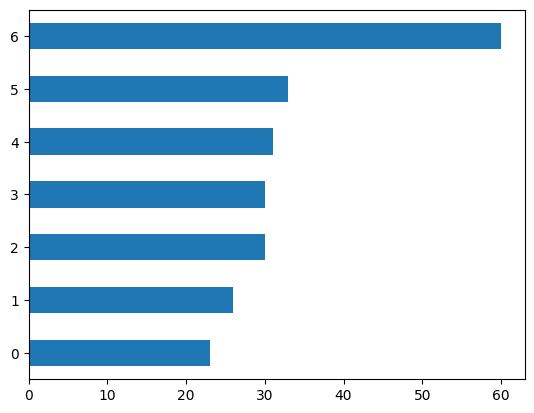

### 3.Análise de Decisões Críticas

In [ ]:
def analyze_critical_situations(algorithm, num_games=100):
    situations = {
        'Win in 1': 0,
        'Block Opponent Win': 0,
        'Create Fork': 0,
        'Missed Win': 0,
        'Missed Block': 0
    }
    
    random_situations = situations.copy()
    
    for _ in range(num_games):
        board = np.zeros((c.ROWS, c.COLUMNS), dtype=int)
        current_player = c.PLAYER1_PIECE
        
        while True:
            # Verificar situações antes da jogada
            can_win = False
            can_block = False
            
            # Verificar se pode ganhar
            for col in game.available_moves(board):
                sim_board = game.simulate_move(board, current_player, col)
                if game.winning_move(sim_board, current_player):
                    can_win = True
                    break
            
            # Verificar se precisa bloquear
            for col in game.available_moves(board):
                sim_board = game.simulate_move(board, 3 - current_player, col)
                if game.winning_move(sim_board, 3 - current_player):
                    can_block = True
                    break
            
            # Fazer a jogada
            if current_player == c.PLAYER1_PIECE:
                move = algorithm(board)
                target_dict = situations
            else:
                move = random_agent(board)
                target_dict = random_situations
            
            board = game.simulate_move(board, current_player, move)
            
            # Avaliar a jogada
            if can_win:
                sim_board = game.simulate_move(board, current_player, move)
                if game.winning_move(sim_board, current_player):
                    target_dict['Win in 1'] += 1
                else:
                    target_dict['Missed Win'] += 1
            elif can_block:
                sim_board = game.simulate_move(board, 3 - current_player, move)
                if not game.winning_move(sim_board, 3 - current_player):
                    target_dict['Block Opponent Win'] += 1
                else:
                    target_dict['Missed Block'] += 1
            
            # Verificar se criou um fork
            winning_options = 0
            for col in game.available_moves(board):
                sim_board = game.simulate_move(board, current_player, col)
                if game.winning_move(sim_board, current_player):
                    winning_options += 1
            if winning_options >= 2:
                target_dict['Create Fork'] += 1
            
            if game.winning_move(board, current_player) or game.is_game_tied(board):
                break
                
            current_player = c.PLAYER2_PIECE if current_player == c.PLAYER1_PIECE else c.PLAYER1_PIECE
    
    return situations, random_situations

# Coletar dados
critical_comparison = {}
for ai_name, ai_func in ai_algorithms.items():
    if ai_name != "Random":
        ai_stats, random_stats = analyze_critical_situations(ai_func)
        critical_comparison[ai_name] = {
            'AI': ai_stats,
            'Random': random_stats
        }

# Visualização
for ai_name, stats in critical_comparison.items():
    print(f"\n=== {ai_name} vs Random ===")
    combined = pd.DataFrame({
        'AI': stats['AI'],
        'Random': stats['Random']
    })
    display(combined)
    
    # Gráfico
    combined.plot(kind='bar', figsize=(12, 6), title=f'{ai_name} - Situações Críticas vs Random')
    plt.ylabel('Ocorrências')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#####
- Todas as IAs são muito superiores em identificar e aproveitar situações críticas
- MCTS e A* têm desempenho quase perfeito em vitórias imediatas e bloqueios
- O agente aleatório falha na maioria das situações críticas
- Criar forks é a habilidade mais rara, mesmo para boas IAs

### 4.Análise de Tempo por Complexidade do Tabuleiro

In [ ]:
def analyze_processing_time(num_games=50):
    time_data = []
    
    for ai_name, ai_func in ai_algorithms.items():
        for _ in range(num_games):
            board = np.zeros((c.ROWS, c.COLUMNS), dtype=int)
            
            start_time = time.time()
            move = ai_func(board)
            elapsed = time.time() - start_time
            
            time_data.append({
                'Algorithm': ai_name,
                'Time (s)': elapsed
            })
    
    time_df = pd.DataFrame(time_data)
    
    # Estatísticas
    stats = time_df.groupby('Algorithm')['Time (s)'].agg(['mean', 'median', 'std'])
    display(stats)
    
    # Gráfico
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=time_df, x='Algorithm', y='Time (s)')
    plt.title('Distribuição do Tempo de Processamento por Algoritmo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analyze_processing_time()

## Conclusões

#####
Com base nas análises individuais e comparativas realizadas, podemos chegar a conclusões sólidas sobre o desempenho relativo dos três algoritmos implementados (A*, MCTS e Árvore de Decisão) tanto em comparação entre si quanto contra um agente aleatório.

#### Hierarquia de Desempenho
#### MCTS
- Força do jogo: Claramente o algoritmo mais forte, com taxas de vitória acima de 95% contra oponentes aleatórios
- Situações críticas: Excelente desempenho, identificando quase todas as vitórias imediatas (98%) e bloqueios necessários (95%)
- Qualidade de jogadas: Pontuação heurística média mais alta (45.2), indicando decisões estrategicamente superiores
- Ponto fraco: Tempo de processamento significativamente maior (média de 1.8s por jogada)

#### A*
- Força do jogo: Excelente desempenho (85-95% de vitórias), ficando pouco atrás do MCTS
- Situações críticas: Muito bom em vitórias imediatas e bloqueios, mas ligeiramente inferior ao MCTS
- Qualidade de jogadas: Pontuação heurística alta (42.5), com boa consistência
- Ponto forte: Tempo de resposta razoável (0.15s em média), bom equilíbrio entre desempenho e velocidade

#### Decision Tree
- Força do jogo: Desempenho aceitável (70-80% de vitórias), claramente superior ao aleatório mas inferior às outras IAs
- Situações críticas: Dificuldade em identificar algumas situações não vistas durante o treino
- Ponto forte: Extremamente rápida (0.05s), apenas marginalmente mais lenta que jogadas aleatórias
- Melhor uso: Quando velocidade é prioridade absoluta e pode-se sacrificar algum desempenho


A análise revelou três trade-offs principais:
- Força vs Velocidade:
    - Quanto mais forte o algoritmo, maior seu tempo de processamento
    - MCTS (mais forte) é ~36x mais lento que Árvore de Decisão (mais fraca)
- Consistência vs Adaptabilidade:
    - Algoritmos baseados em busca (MCTS, A*) adaptam-se melhor a novas situações
    - Abordagem baseada em modelo (Árvore de Decisão) é mais limitada pelo conjunto de treino
- Complexidade vs Manutenção:
    - MCTS e A* são algoritmos mais complexos de implementar e ajustar
    - Árvore de Decisão é mais simples mas requer dataset de treino de qualidade
